# Цель работы

Дан многомерный размеченный набор данных. Необходимо выполнить предиктивный анализ данных на основе регрессионных моделей в соответствии со следующей последовательностью этапов.

# Ход работы

1. Загрузить необходимые пакеты и библиотеки.
2. Загрузить данные из указанного источника.
3. Выполнить разведочный анализ данных в соответствии с этапами описанными в файле Этапы проекта машинного обучения в примерах 1/2.pdf:

    a. Ознакомление с данными с помощью методов описательной статистики;
    
    b. Выполнить визуализацию данных одномерную для понимания распределения данных и многомерную для выяснения зависимостей между признаками;
    
    c. При необходимости выполнить очистку данных одним из методов.
    
    d. Проанализировать корреляционную зависимость между признаками;
    
    e. Поэкспериментировать с комбинациями атрибутов. При необходимости добавить новые атрибуты в набор данных.
    
    f. Выполнить отбор существенных признаков. Сформировать набор данных из существенных признаков.
    
    g. При необходимости преобразовать текстовые или категориальные признаки одним из методов.
    
    h. Выполнить преобразование данных для обоих наборов (исходного и сформированного) одним из методов по варианту.
    
4. В имеющихся двух наборах данных (исходном и их существенных признаков) выделить обучающую и тестовую выборки данных.
5. Сравнить линейную (по варианту) и полиномиальную регрессионные модели на обучающих выборках для обоих наборов данных. Для оценки качества моделей использовать метрики: корень из среднеквадратичной ошибки, R2.
6. Для лучшей модели на лучшем наборе данных выполнить Grid поиск лучшего гиперпараметра регрессионной модели на обучающей выборке. Построить графики результатов поиска. Определить значение лучшего гиперпараметра.
7. Для лучшей модели на лучшем наборе данных выполнить Grid поиск лучшего гиперпараметра регрессионной модели на тестовом выборке. Построить графики результатов поиска. Скорректировать значение лучшего гиперпараметра модели.
8. Сделать выводы по проведенному анализу.

# Исходные данные

Вариант 2.

Набор данных цен на недвижимость. Построить регрессионную модель для целевого признака «Y house price of unit area» (цена объекта недвижимости) от
остальных входных признаков.

- Пункт 3.h – Стандартизация
- Пункт 4 – эластичная сеть (регуляризованная линейная регрессия)

# Выполнение работы

## Загрузка используемых пакетов библиотек

In [32]:
import tarfile
import urllib.request
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from pickle import dump
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

%matplotlib inline
pd.options.mode.chained_assignment = None

## Загрузка исходных данных

In [2]:
HOUSING_URL = 'https://github.com/Demetrey/DMaP/blob/master/LR1/datasets/LR1_datasets.tar.gz?raw=true'
HOUSING_PATH = os.path.join('datasets', 'housing')

In [3]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, 'LR1_datasets.tar.gz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
fetch_housing_data()
HOUSING_FILENAME = os.path.join(HOUSING_PATH, 'V2.csv')

In [5]:
def load_housing_data(path=HOUSING_FILENAME):
    df = pd.read_csv(path)
    # Первые 2 столбца содержат нумерацию 
    df.drop(['Unnamed: 0', 'No'], axis=1, inplace=True)  # inplace - изменение текущего df
    return df

In [6]:
housing = load_housing_data()

## Разведочный анализ данных

### Просмотр первых данных

In [7]:
housing.head()

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,NaN,561.98450,5,24.98746,121.54391,47.3
3,2013.500,NaN,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


Описание столбцов:
- X1 transaction date - дата транзакции;
- X2 house age - возраст дома;
- X3 distance to the nearest MRT station - расстояние до ближайшей станции метро;
- X4 number of convenience stores - количество магазинов шаговой доступности;
- X5 latitude - широта;
- X6 longitude - долгота;
- Y house price of unit area - стоимость за единицу площади.

### Определение размерности и типов данных

### Получение более подробной информации

In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   X1 transaction date                     414 non-null    float64
 1   X2 house age                            205 non-null    float64
 2   X3 distance to the nearest MRT station  414 non-null    float64
 3   X4 number of convenience stores         414 non-null    int64  
 4   X5 latitude                             414 non-null    float64
 5   X6 longitude                            414 non-null    float64
 6   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 22.8 KB


В столбце X2 содержится 205 не пустых значений из 414.

### (a) Вывод описательной статистики

In [9]:
housing.describe()

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
count,414.000000,205.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2013.148971,18.206829,1083.885689,4.094203,24.969030,121.533361,37.980193
std,0.281967,11.747338,1262.109595,2.945562,0.012410,0.015347,13.606488
min,2012.667000,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,2012.917000,9.000000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,2013.167000,16.200000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,2013.417000,30.300000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,2013.583000,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


### (b) Визуализация данных

#### Гистограммы

array([[<AxesSubplot:title={'center':'X1 transaction date'}>,
        <AxesSubplot:title={'center':'X2 house age'}>,
        <AxesSubplot:title={'center':'X3 distance to the nearest MRT station'}>],
       [<AxesSubplot:title={'center':'X4 number of convenience stores'}>,
        <AxesSubplot:title={'center':'X5 latitude'}>,
        <AxesSubplot:title={'center':'X6 longitude'}>],
       [<AxesSubplot:title={'center':'Y house price of unit area'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

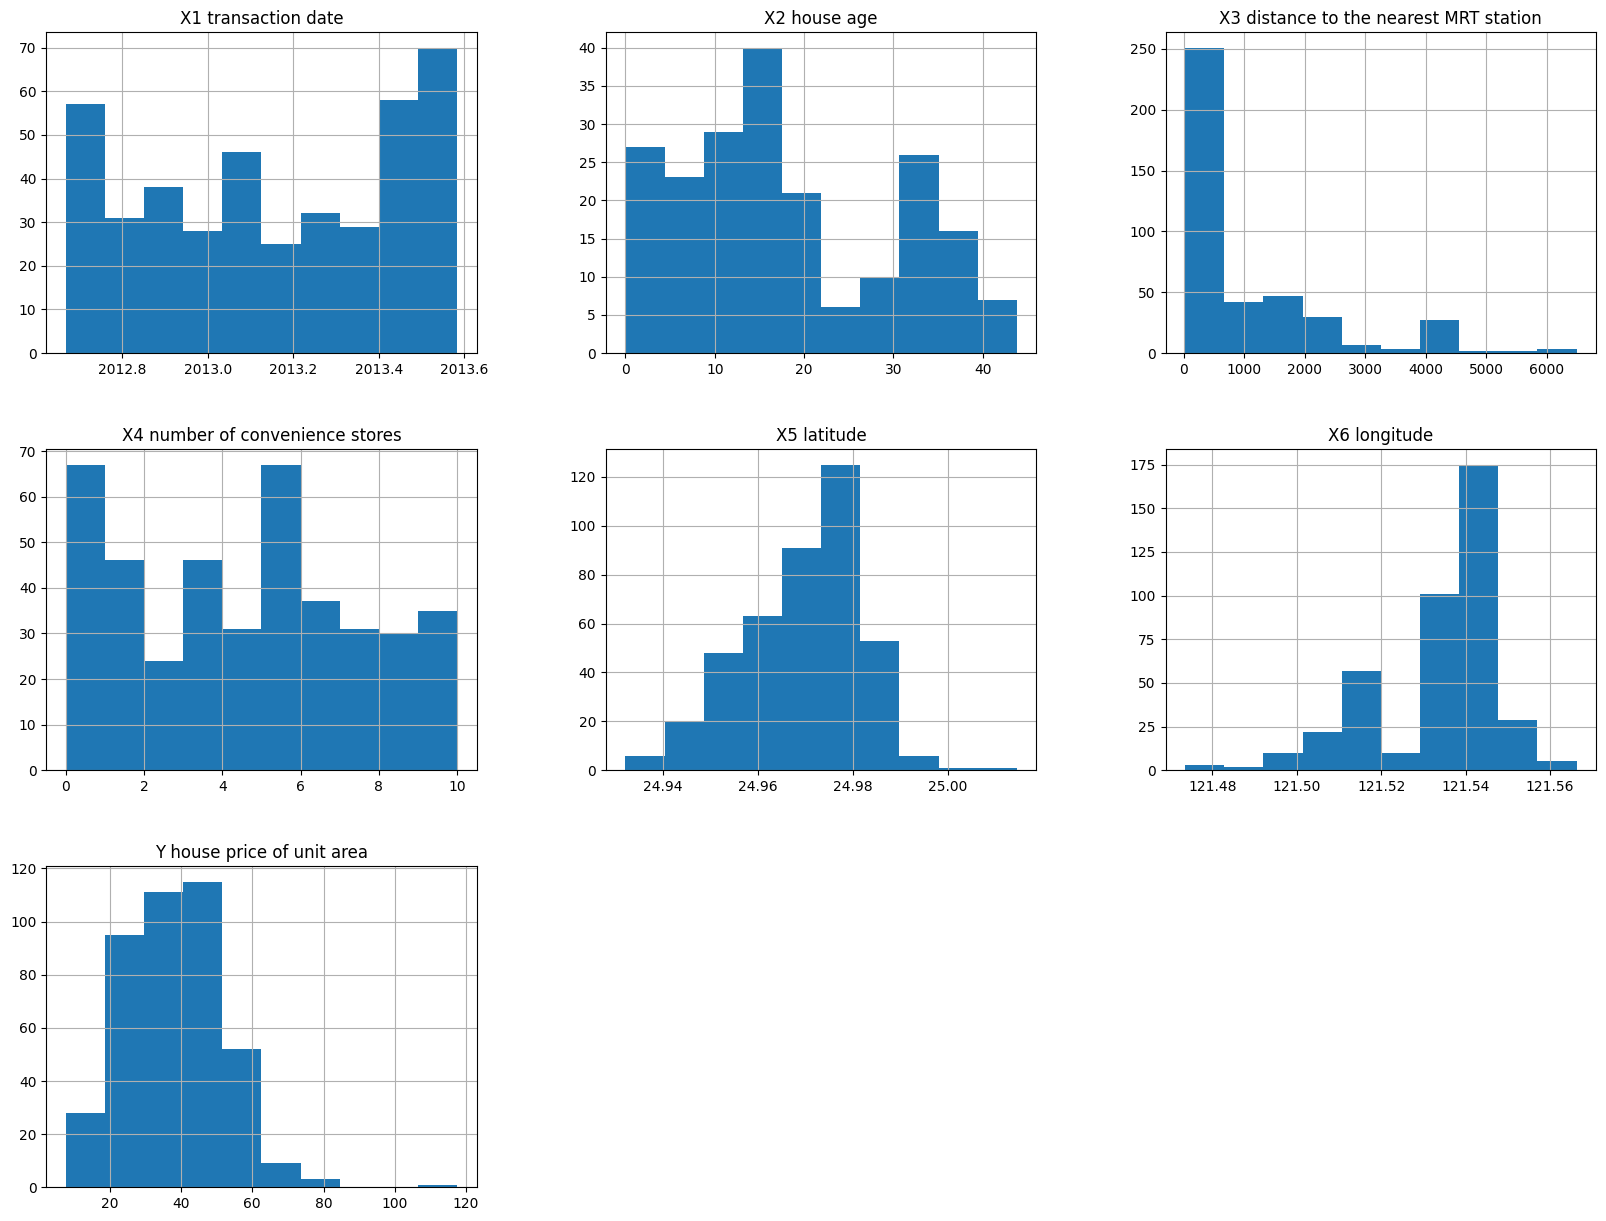

In [10]:
housing.hist(bins=10, figsize=(20, 15))

#### Графики плотности распределения

array([[<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
        <AxesSubplot:ylabel='Density'>],
       [<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
        <AxesSubplot:ylabel='Density'>],
       [<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
        <AxesSubplot:ylabel='Density'>]], dtype=object)

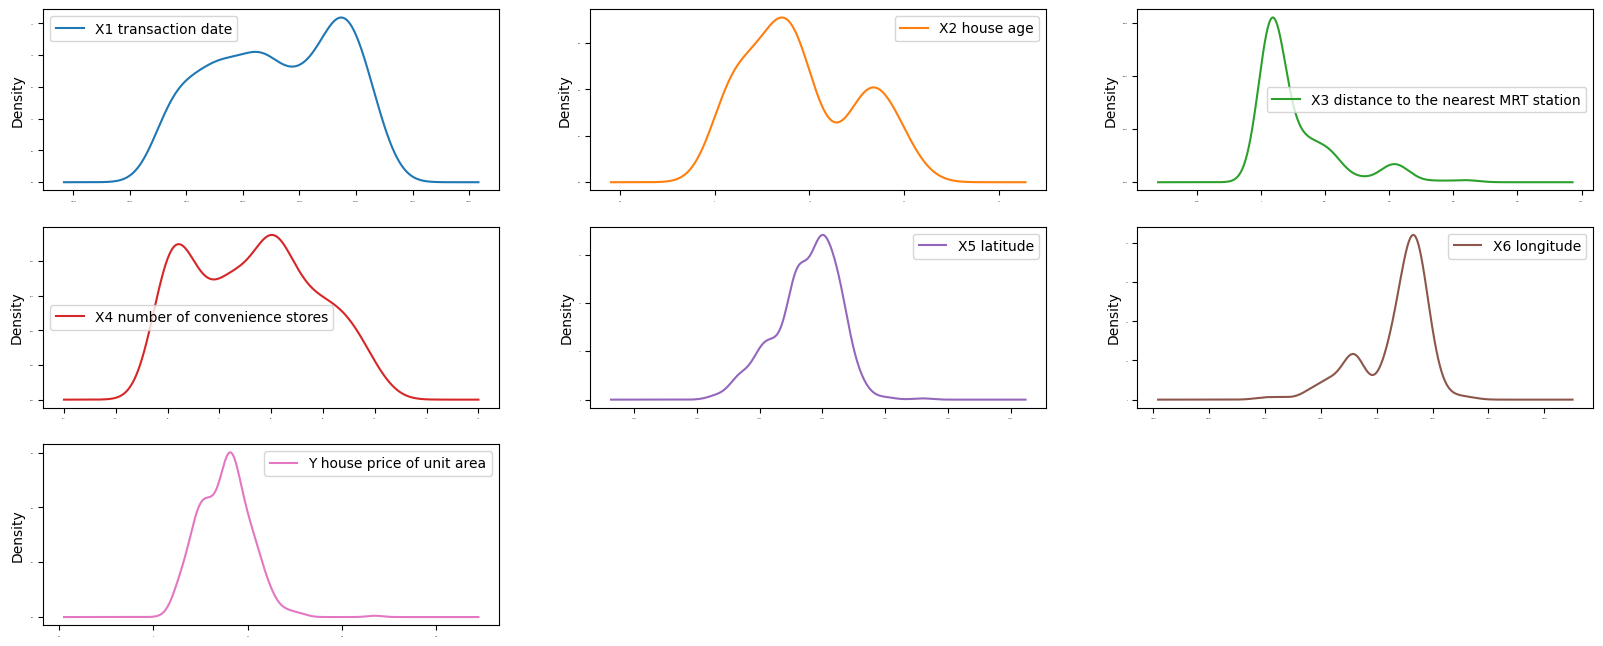

In [11]:
housing.plot(kind='density', subplots=True, layout=(3, 3), sharex=False, legend=True, fontsize=1, figsize=(20,8))

#### График корреляционной матрицы

                                        X1 transaction date  X2 house age  \
X1 transaction date                                1.000000     -0.073917   
X2 house age                                      -0.073917      1.000000   
X3 distance to the nearest MRT station             0.060880     -0.017422   
X4 number of convenience stores                    0.009635      0.109612   
X5 latitude                                        0.035058      0.036341   
X6 longitude                                      -0.041082      0.014261   
Y house price of unit area                         0.087491     -0.195321   

                                        X3 distance to the nearest MRT station  \
X1 transaction date                                                   0.060880   
X2 house age                                                         -0.017422   
X3 distance to the nearest MRT station                                1.000000   
X4 number of convenience stores                        

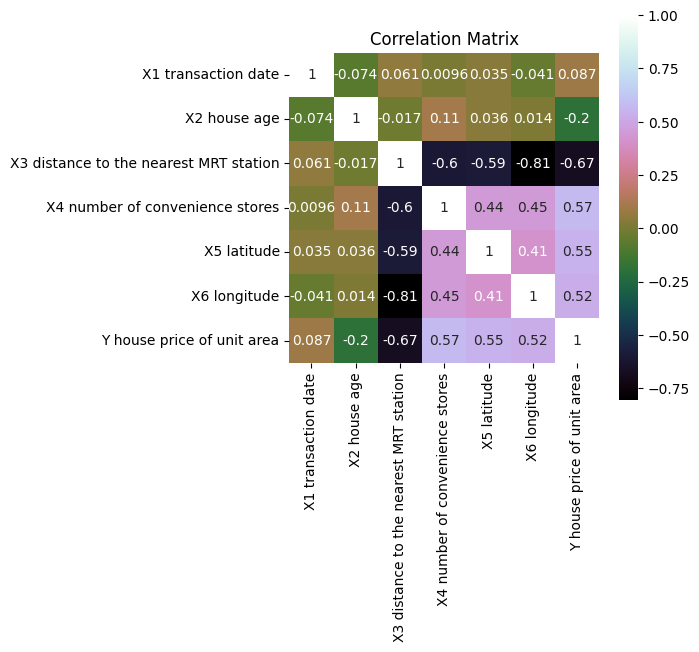

In [12]:
correlation = housing.corr()
plt.figure(figsize=(5, 5))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')
print(correlation)

#### Диаграмма рассеивания

array([[<AxesSubplot:xlabel='X1 transaction date', ylabel='X1 transaction date'>,
        <AxesSubplot:xlabel='X2 house age', ylabel='X1 transaction date'>,
        <AxesSubplot:xlabel='X3 distance to the nearest MRT station', ylabel='X1 transaction date'>,
        <AxesSubplot:xlabel='X4 number of convenience stores', ylabel='X1 transaction date'>,
        <AxesSubplot:xlabel='X5 latitude', ylabel='X1 transaction date'>,
        <AxesSubplot:xlabel='X6 longitude', ylabel='X1 transaction date'>,
        <AxesSubplot:xlabel='Y house price of unit area', ylabel='X1 transaction date'>],
       [<AxesSubplot:xlabel='X1 transaction date', ylabel='X2 house age'>,
        <AxesSubplot:xlabel='X2 house age', ylabel='X2 house age'>,
        <AxesSubplot:xlabel='X3 distance to the nearest MRT station', ylabel='X2 house age'>,
        <AxesSubplot:xlabel='X4 number of convenience stores', ylabel='X2 house age'>,
        <AxesSubplot:xlabel='X5 latitude', ylabel='X2 house age'>,
        <AxesSubpl

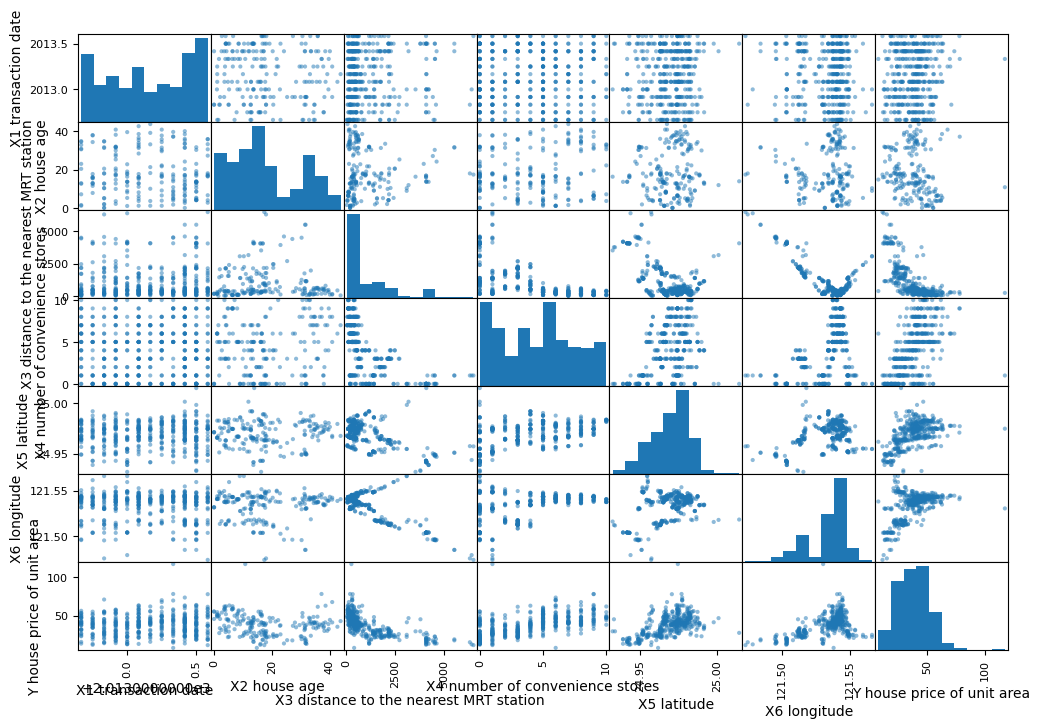

In [13]:
scatter_matrix(housing, figsize=(12, 8))

#### (с) Выполним очистку данных

Проведем очистку данных несколькими методами:
- удалим соответствующие записи;
- установим недостающие значения на медиану;
- установим недостающие значения на среднее;
- установим недостающие значения на 0.

In [14]:
lst_housing_X2_Y = [housing.iloc[:, [1, 6]] for _ in range(4)]
lst_housing_X2_Y[0].dropna(inplace=True)  # Удаление строк
# заполнение медианой
median = lst_housing_X2_Y[1][housing.columns[1]].median()
lst_housing_X2_Y[1][housing.columns[1]].fillna(median, inplace=True)
# заполнение средним
avg = lst_housing_X2_Y[2][housing.columns[1]].mean()
lst_housing_X2_Y[2][housing.columns[1]].fillna(avg, inplace=True)
# заполнение нулем
lst_housing_X2_Y[3][housing.columns[1]].fillna(0, inplace=True)

Построим корреляционные матрицы

In [15]:
for tab in lst_housing_X2_Y:
    print(tab.corr())

                            X2 house age  Y house price of unit area
X2 house age                    1.000000                   -0.195321
Y house price of unit area     -0.195321                    1.000000
                            X2 house age  Y house price of unit area
X2 house age                    1.000000                   -0.143517
Y house price of unit area     -0.143517                    1.000000
                            X2 house age  Y house price of unit area
X2 house age                    1.000000                   -0.144392
Y house price of unit area     -0.144392                    1.000000
                            X2 house age  Y house price of unit area
X2 house age                    1.000000                   -0.098057
Y house price of unit area     -0.098057                    1.000000


По результатам построения корреляционных матриц, можно сделать вывод, что замена значений и удаление соответствующих записей не дает улучшений значения коэффициента корреляции по сравнению с исходными значениями корреляционной матрицы. По сравнению с другими параметрами (X3-X6), X2 имеет малый коэффициент корреляции, им можно пренеберечь.

In [16]:
housing.drop([housing.columns[1]], axis=1, inplace=True)
housing

,X1 transaction date,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,2012.917,84.87882,10,24.98298,121.54024,37.9
1,2012.917,306.59470,9,24.98034,121.53951,42.2
2,2013.583,561.98450,5,24.98746,121.54391,47.3
3,2013.500,561.98450,5,24.98746,121.54391,54.8
4,2012.833,390.56840,5,24.97937,121.54245,43.1
...,...,...,...,...,...,...
409,2013.000,4082.01500,0,24.94155,121.50381,15.4
410,2012.667,90.45606,9,24.97433,121.54310,50.0
411,2013.250,390.96960,7,24.97923,121.53986,40.6
412,2013.000,104.81010,5,24.96674,121.54067,52.5


#### (d) Анализ корелляционной зависимости между признаками

<AxesSubplot:title={'center':'Correlation Matrix'}>

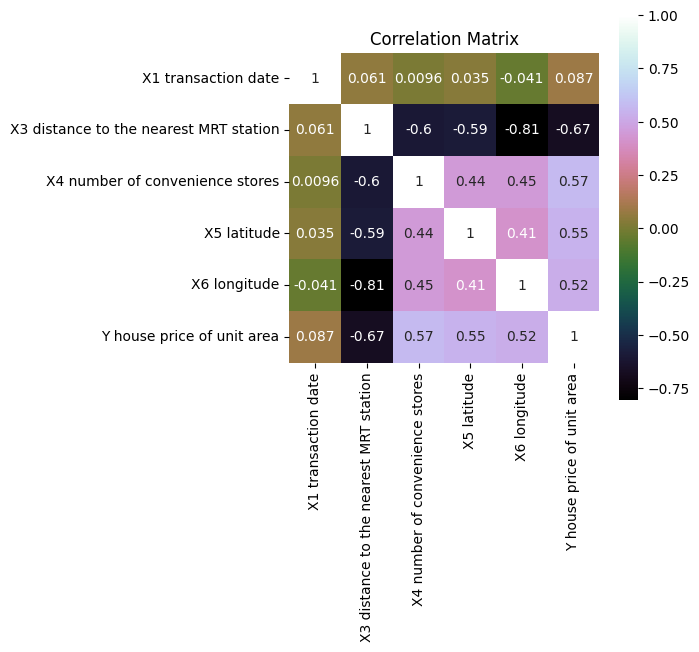

In [17]:
correlation = housing.corr()
plt.figure(figsize=(5, 5))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')

#### Вывод сортированных значений коэффициентов корреляции по Y

In [18]:
correlation[housing.columns[-1]].sort_values(ascending=False)

Y house price of unit area                1.000000
X4 number of convenience stores           0.571005
X5 latitude                               0.546307
X6 longitude                              0.523287
X1 transaction date                       0.087491
X3 distance to the nearest MRT station   -0.673613
Name: Y house price of unit area, dtype: float64

Согласно интерпретации коэффициента корреляции по шкале Чеддока, значение коэффициента корреляции X1 близко к 0, что означает отсутствие линейной корреляции. X4-X6 - средняя положительная корреляция, X3 - средняя отрицательная корреляция.

<AxesSubplot:xlabel='X3 distance to the nearest MRT station', ylabel='Y house price of unit area'>

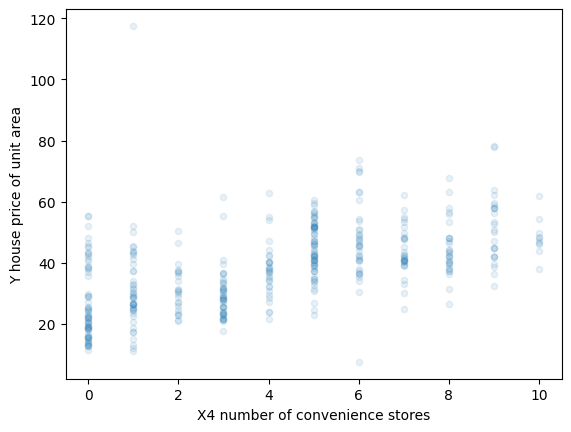

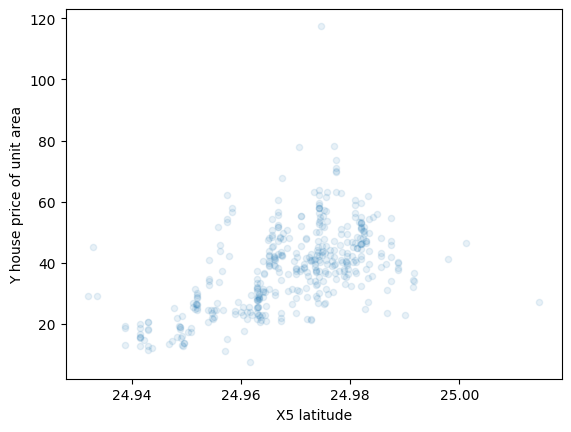

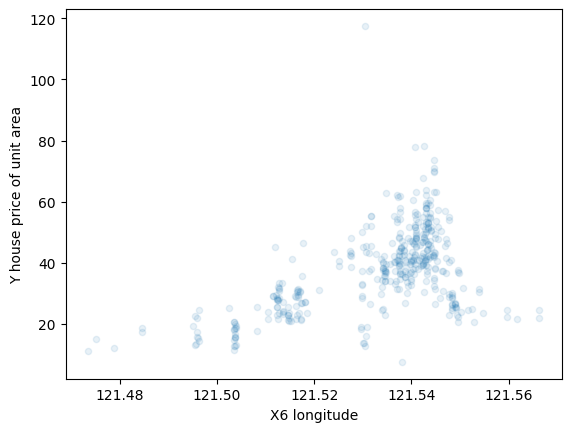

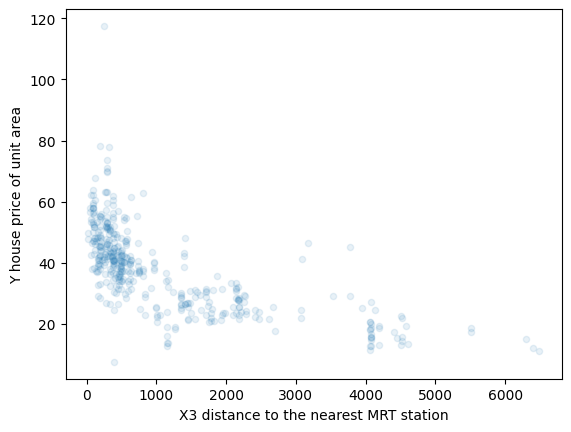

In [28]:
housing.plot(kind='scatter', x = 'X4 number of convenience stores', y = 'Y house price of unit area', alpha=0.1)
housing.plot(kind='scatter', x = 'X5 latitude', y = 'Y house price of unit area', alpha=0.1)
housing.plot(kind='scatter', x = 'X6 longitude', y = 'Y house price of unit area', alpha=0.1)
housing.plot(kind='scatter', x = 'X3 distance to the nearest MRT station', y = 'Y house price of unit area', alpha=0.1)

#### (e) Комбинации атрибутов

Так как по логике и здравому смыслу объединить атрибуты мы не можем, выполним полный перебор
**???????????????**

In [19]:
indexes = []
for i in range(4):
    for j in range(i + 1, 5):
        print('\n\n\n', housing.columns[i], '\t' ,housing.columns[j])
        t1 = housing[housing.columns[i]] / housing[housing.columns[j]]
        t2 = housing[housing.columns[j]] / housing[housing.columns[i]]
        d = {'t1': t1, 't2': t2, 'y': housing[housing.columns[-1]]}
        df = pd.DataFrame(data=d)
        correlation = df.corr()
        print(correlation['y'].sort_values(ascending=False))




 X1 transaction date 	 X3 distance to the nearest MRT station
y     1.000000
t1    0.455805
t2   -0.673631
Name: y, dtype: float64



 X1 transaction date 	 X4 number of convenience stores
y     1.000000
t2    0.570986
t1   -0.399810
Name: y, dtype: float64



 X1 transaction date 	 X5 latitude
y     1.000000
t2    0.506759
t1   -0.506887
Name: y, dtype: float64



 X1 transaction date 	 X6 longitude
y     1.000000
t2    0.279757
t1   -0.279823
Name: y, dtype: float64



 X3 distance to the nearest MRT station 	 X4 number of convenience stores
y     1.000000
t2    0.431922
t1   -0.503675
Name: y, dtype: float64



 X3 distance to the nearest MRT station 	 X5 latitude
y     1.000000
t2    0.455841
t1   -0.673608
Name: y, dtype: float64



 X3 distance to the nearest MRT station 	 X6 longitude
y     1.000000
t2    0.455754
t1   -0.673574
Name: y, dtype: float64



 X4 number of convenience stores 	 X5 latitude
y     1.000000
t1    0.570954
t2   -0.399644
Name: y, dtype: float64



 X4

#### (f) Отбор существенных (информативных) признаков

In [20]:
housing_X = housing.iloc[:, 0:5]
housing_Y = housing['Y house price of unit area']
bestfeatures = SelectKBest(k=5)
fit = bestfeatures.fit(housing_X, housing_Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(housing_X.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores

,0,0
0,X1 transaction date,0.993150
1,X3 distance to the nearest MRT station,4.792860
2,X4 number of convenience stores,2.010420
3,X5 latitude,2.353937
4,X6 longitude,1.903160


Исходя из полученных значений, наиболее информативными признаками являются X3-X6. Уберем данный столбец.

#### (g) Стандартизация

In [23]:
housing_x = housing.iloc[:, :5]  # отбираем иксы
scaler = StandardScaler().fit(housing_x)
starter_housing = pd.DataFrame(scaler.fit_transform(housing_x))
shousing_x = starter_housing.drop(0, axis=1)
print(shousing_x)
print(starter_housing)

            1         2         3         4
0   -0.792495  2.007407  1.125430  0.448762
1   -0.616612  1.667503  0.912444  0.401139
2   -0.414015  0.307885  1.486860  0.688183
3   -0.414015  0.307885  1.486860  0.688183
4   -0.549997  0.307885  0.834188  0.592937
..        ...       ...       ...       ...
409  2.378365 -1.391638 -2.216993 -1.927835
410 -0.788071  1.667503  0.427579  0.635341
411 -0.549678  0.987694  0.822893  0.423972
412 -0.776684  0.307885 -0.184755  0.476814
413 -0.788071  1.667503  0.427579  0.635341

[414 rows x 4 columns]
            0         1         2         3         4
0   -0.823683 -0.792495  2.007407  1.125430  0.448762
1   -0.823683 -0.616612  1.667503  0.912444  0.401139
2    1.541151 -0.414015  0.307885  1.486860  0.688183
3    1.246435 -0.414015  0.307885  1.486860  0.688183
4   -1.121951 -0.549997  0.307885  0.834188  0.592937
..        ...       ...       ...       ...       ...
409 -0.528967  2.378365 -1.391638 -2.216993 -1.927835
410 -1.711384 -0

Сохраним модель

In [35]:
save_data = pd.concat([shousing_x, housing[housing.columns[-1]]], axis=1)
save_name = 'funale_model.sav'
save_path = os.path.join(HOUSING_PATH, save_name)
dump(shousing_x, open(save_path, 'wb'))

### Выделим обучающую и тестовую выборки

Размер тестовой выборки: 20%

In [84]:
validation_size = 0.2
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(shousing_x, housing_Y, test_size=validation_size, random_state=seed)
X_train_s, X_test_s, Y_train_s, Y_test_s = train_test_split(starter_housing, housing_Y, test_size=validation_size, random_state=seed)

### Применение линейной регрессии (эластичная сеть)

In [83]:
def f(x, y):
    model = ElasticNet(alpha=0.5)
    model.fit(x, y)
    Y_pred = model.predict(x)
    rmse_elnet = np.sqrt(mean_squared_error(y, Y_pred))
    r2_elnet = r2_score(y, Y_pred)
    print("RMSE for Elastic Net:", rmse_elnet)
    print("R2_score for Elastic Net:", r2_elnet)
    return Y_pred

RMSE for Elastic Net: 9.877639032552972
R2_score for Elastic Net: 0.5173876384902331


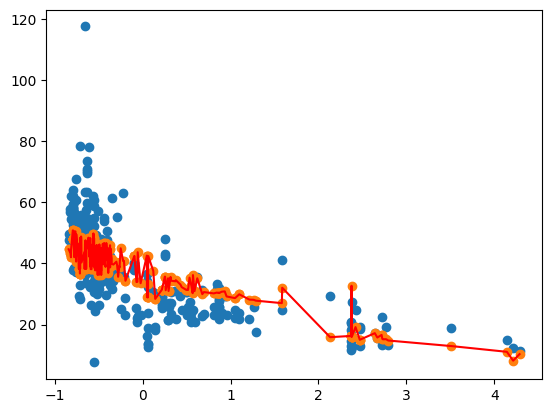

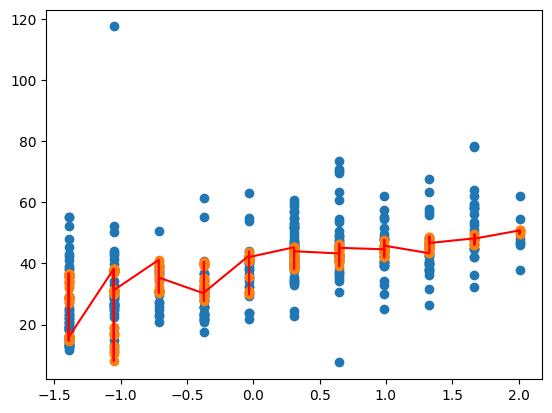

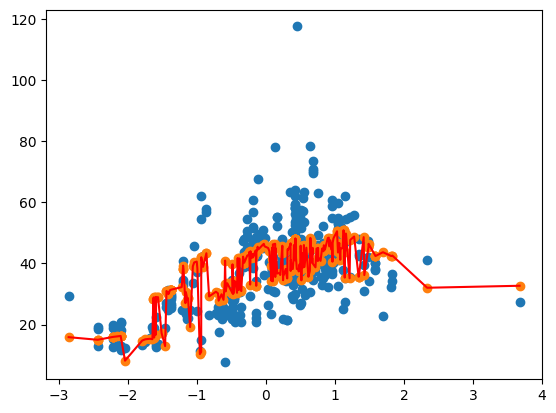

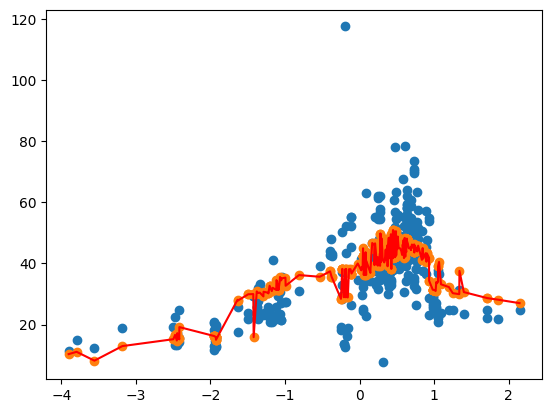

In [85]:
Y_pred = f(X_train, Y_train)

i = 1
for x in X_train:
    plt.figure()
    sort_xy = pd.DataFrame({'X': X_train[x], 'Y': Y_pred})
    sort_xy = sort_xy.sort_values(by='X')
    plt.plot(X_train[x], Y_train, 'o')
    plt.plot(X_train[x], Y_pred, 'o')
    plt.plot(sort_xy.X, sort_xy.Y, "r-")

RMSE for Elastic Net: 9.774855001937695
R2_score for Elastic Net: 0.5273792480860923


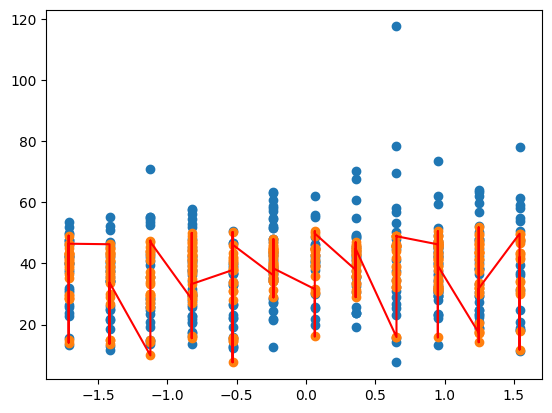

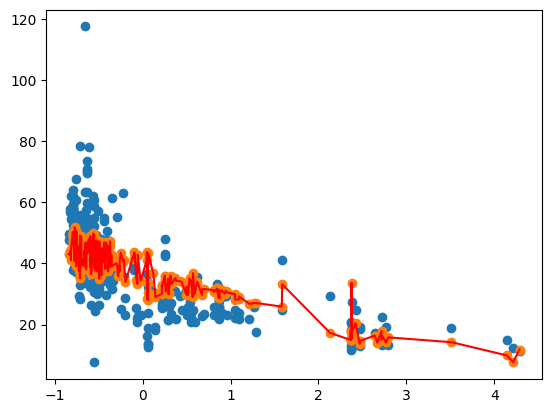

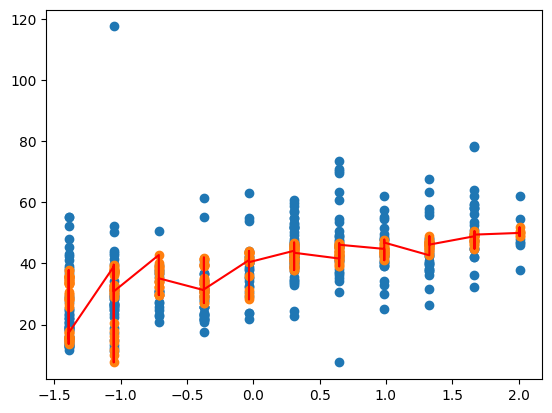

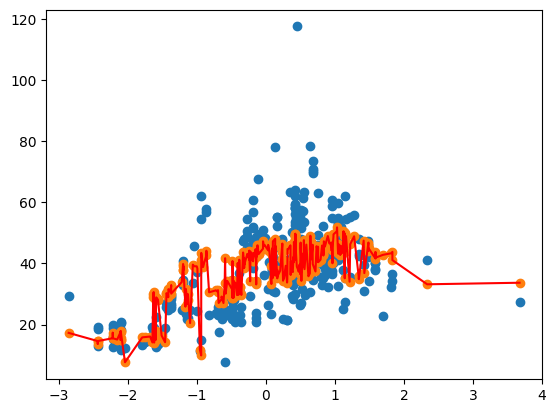

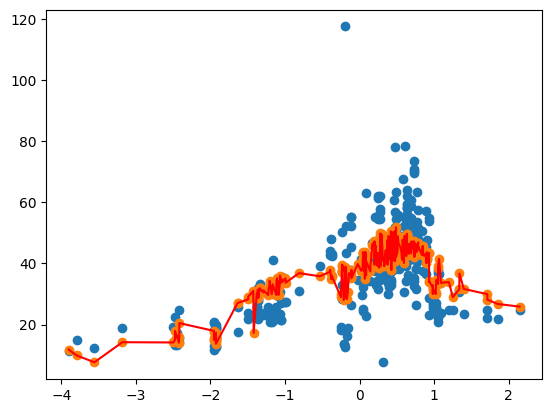

In [87]:
Y_pred = f(X_train_s, Y_train_s)

for x in X_train_s:
    plt.figure()
    sort_xy = pd.DataFrame({'X': X_train_s[x], 'Y': Y_pred})
    sort_xy = sort_xy.sort_values(by='X')
    plt.plot(X_train_s[x], Y_train, 'o')
    plt.plot(X_train_s[x], Y_pred, 'o')
    plt.plot(sort_xy.X, sort_xy.Y, "r-")

RMSE for Elastic Net: 10.69712133527611
R2_score for Elastic Net: 0.43398755145291446


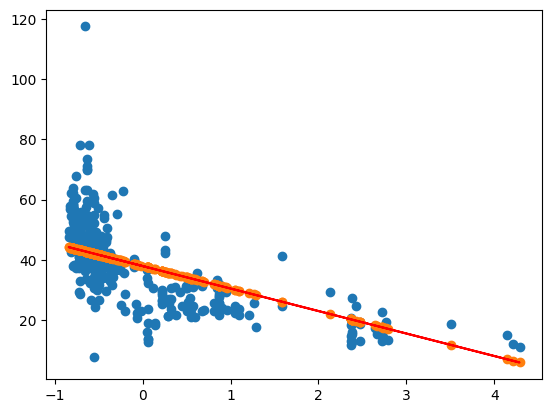

In [89]:
X_train, X_test, Y_train, Y_test = train_test_split(shousing_x.iloc[:, :1], housing_Y, test_size=validation_size, random_state=seed)

model = ElasticNet(alpha=0.5)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_train)
rmse_elnet = np.sqrt(mean_squared_error(Y_train, Y_pred))
r2_elnet = r2_score(Y_train, Y_pred)
print("RMSE for Elastic Net:", rmse_elnet)
print("R2_score for Elastic Net:", r2_elnet)

plt.plot(X_train[1], Y_train, 'o')
plt.plot(X_train[1], Y_pred, 'o')
plt.plot(X_train[1], Y_pred, "r-")